<a href="https://colab.research.google.com/github/vic-torr/thesis-experiments/blob/main/experiments/shm_lr_1_10_epoch_of_Final_Focal_loss_rsp_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config

In [ ]:
VERSION = 'shm_lr_1_10-epoch_final'
OVERWRITE_CHECKPOINT = False    
RECOVER_PAST_TRAINNING = True
TRAIN = False
# Rsp swin t from https://github.com/ViTAE-Transformer/ViTAE-Transformer-Remote-Sensing
# loss function imbalanced classes

import sys, os
RunningInCOLAB = 'google.colab' in sys.modules

BATCH_SIZE = 64
if RunningInCOLAB:
    BATCH_SIZE = 64

FEATURES = 17
IMG_SIZE = 224
LR = 1e-4
LR_STEP_SIZE = 1
GAMMA = 0.9
N_EPOCHS = 10
MODEL_ARCH = ['rsp-swin-t', 'rsp-resnet-50', 'swin_t_IMAGENET', 'resnet50_IMAGENET']

#MODEL = 'rsp-swin-t'
MODEL = 'rsp-resnet-50'


weights_models = {'rsp-swin-t': 'rsp-swin-t-ckpt.pth', 'swin_t_IMAGENET': 'IMAGENET1K_V1',
                      'rsp-resnet-50' : 'rsp-resnet-50-ckpt.pth', 'resnet50_IMAGENET':'' }

weights_filename = weights_models[MODEL]

config = {"BATCH_SIZE": BATCH_SIZE,"IMG_SIZE": IMG_SIZE,"LR": LR,"LR_STEP_SIZE": LR_STEP_SIZE,
          "GAMMA": GAMMA,"N_EPOCHS": N_EPOCHS,"VERSION": VERSION,"PRETRAIN_WEIGHTS": weights_filename}
      

# Set Environment

In [ ]:
if RunningInCOLAB:
    from google.colab import drive, files, runtime

    drive.mount('/content/drive', force_remount=True)
    !unzip -n /content/drive/MyDrive/Colab-Notebooks/datasets/planet.zip -d /dev/shm/ &> /dev/null;
    %clear
    checkpoint_path_dir = '/content/drive/MyDrive/Colab-Notebooks/checkpoints/'
    dataset_dir="/dev/shm/planet/"
    experiment_results = f'drive/MyDrive/Colab-Notebooks/results/{MODEL}_{VERSION}'
    %mkdir -p ${experiment_results}
else:
    home = os.environ['HOME']
    dataset_dir = home + "/UFMG/Thesis/datasets/planet"
    checkpoint_path_dir = home +'/UFMG/Thesis/Experiments/checkpoints/'
    experiment_results = home + f'/UFMG/Thesis/Experiments/results/{MODEL}_{VERSION}/'
    %mkdir -p ${experiment_results}

results_path = checkpoint_path_dir + f"train_results_{MODEL}_{VERSION}.pkl"
checkpoint_path = checkpoint_path_dir + f"{MODEL}_{VERSION}.pth"
weights_path = checkpoint_path_dir + f"{weights_filename}"          


Mounted at /content/drive
/bin/bash: module: No such file or directory


In [ ]:
if RunningInCOLAB:
    %pip install torch torchvision sklearn dill tqdm plotly matplotlib torchinfo opencv-python timm yacs seaborn kaleido
    %clear

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
path = dataset_dir
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
total_train_files = len(os.listdir(path_train))
print(f"train files: {total_train_files}, "
    f"test files: {len(os.listdir(path_test))}")

train files: 40479, test files: 40669


# Libs

In [ ]:
from collections import Counter
from copy import copy, deepcopy
from glob import glob
from matplotlib import pyplot as plt
from PIL import Image
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, precision_recall_fscore_support, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from time import time
from torch import nn, Tensor
from torch.autograd import Variable
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torchvision import transforms, models
from tqdm.notebook import tqdm
import threading
import cv2
import dill as pickle
import gc
import numpy as np  # Torch wrapper for Numpy
import os
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import random
import seaborn as sns
import threading
import timm
import torch
import torch.optim as optim

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


In [ ]:
def clear_cache():
    if RunningInCOLAB:
        torch.cuda.empty_cache()
    gc.collect()

In [ ]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results

    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(2022)

# EDA

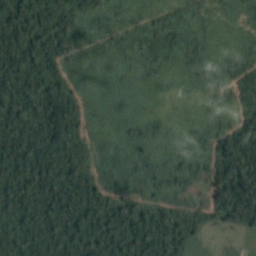

In [ ]:
display(Image.open(path_train+'/train_333.jpg').convert("RGB"))

In [ ]:
path_class = os.path.join(path, "train_classes.csv")
df_class = pd.read_csv(path_class)
print(df_class.shape)

(40479, 2)


In [ ]:
label_list = []
for tag_str in df_class.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
# Histogram of label instances
#df_class[label_list].sum().sort_values().plot.bar()      

# Add onehot features for every label
for label in label_list:
    df_class[label] = df_class['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
df_class.head()

image_name                                       tags  haze  primary  \
0    train_0                               haze primary     1        1   
1    train_1            agriculture clear primary water     0        1   
2    train_2                              clear primary     0        1   
3    train_3                              clear primary     0        1   
4    train_4  agriculture clear habitation primary road     0        1   

   agriculture  clear  water  habitation  road  cultivation  slash_burn  \
0            0      0      0           0     0            0           0   
1            1      1      1           0     0            0           0   
2            0      1      0           0     0            0           0   
3            0      1      0           0     0            0           0   
4            1      1      0           1     1            0           0   

   cloudy  partly_cloudy  conventional_mine  bare_ground  artisinal_mine  \
0       0              0                  0            0               0   
1       0              0                  0            0               0   
2       0              0                  0            0               0   
3       0              0                  0            0               0   
4       0              0                  0            0               0   

   blooming  selective_logging  blow_down  
0         0                  0          0  
1         0                  0          0  
2         0                  0          0  
3         0                  0          0  
4         0                  0          0

In [ ]:
experiment_results = "drive/MyDrive/Colab-Notebooks/results/rsp-resnet-50"
%mkdir -p ${experiment_results}

/bin/bash: module: No such file or directory


In [ ]:
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

fig = px.bar(df_tags, x="total", y="tag", orientation="h", color="total",)
title = 'Class distribution'
fig.update_layout(title="Tags distribution", width=1000, height=500)
fig.show()
fig.write_image(experiment_results+title+".jpg")

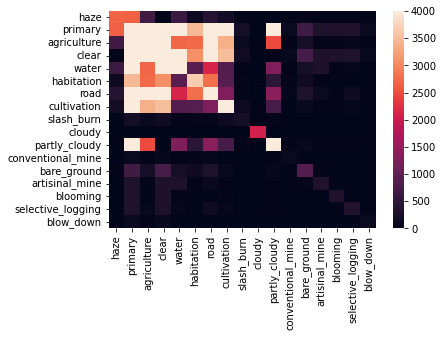

In [ ]:
def make_cooccurence_matrix(labels):
    numeric_df = df_class[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    title = 'Co-occurrence matrix'
    fig = sns.heatmap(c_matrix, vmax=4000)
    fig.get_figure().savefig(experiment_results+title+".jpg")
    return c_matrix
    
# Compute the co-ocurrence matrix
c_matrix = make_cooccurence_matrix(label_list)

In [ ]:
RARE_CLASSES = ["bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"]
CLIMATE_CLASSES = ["clear", "partly_cloudly", "haze", "cloudy"]

## Train-Test split 80%-20%

In [ ]:
df_train, df_val = train_test_split(df_class, test_size=.2)
ds_train_size, ds_val_size = df_train['tags'].size, df_val['tags'].size
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 2.0690% (670)
val bare_ground: 2.3715% (192)

train selective_logging: 0.7967% (258)
val selective_logging: 1.0128% (82)

train artisinal_mine: 0.8369% (271)
val artisinal_mine: 0.8399% (68)

train blooming: 0.8245% (267)
val blooming: 0.8029% (65)

train slash_burn: 0.5188% (168)
val slash_burn: 0.5064% (41)

train blow_down: 0.2254% (73)
val blow_down: 0.3088% (25)

train conventional_mine: 0.2470% (80)
val conventional_mine: 0.2470% (20)



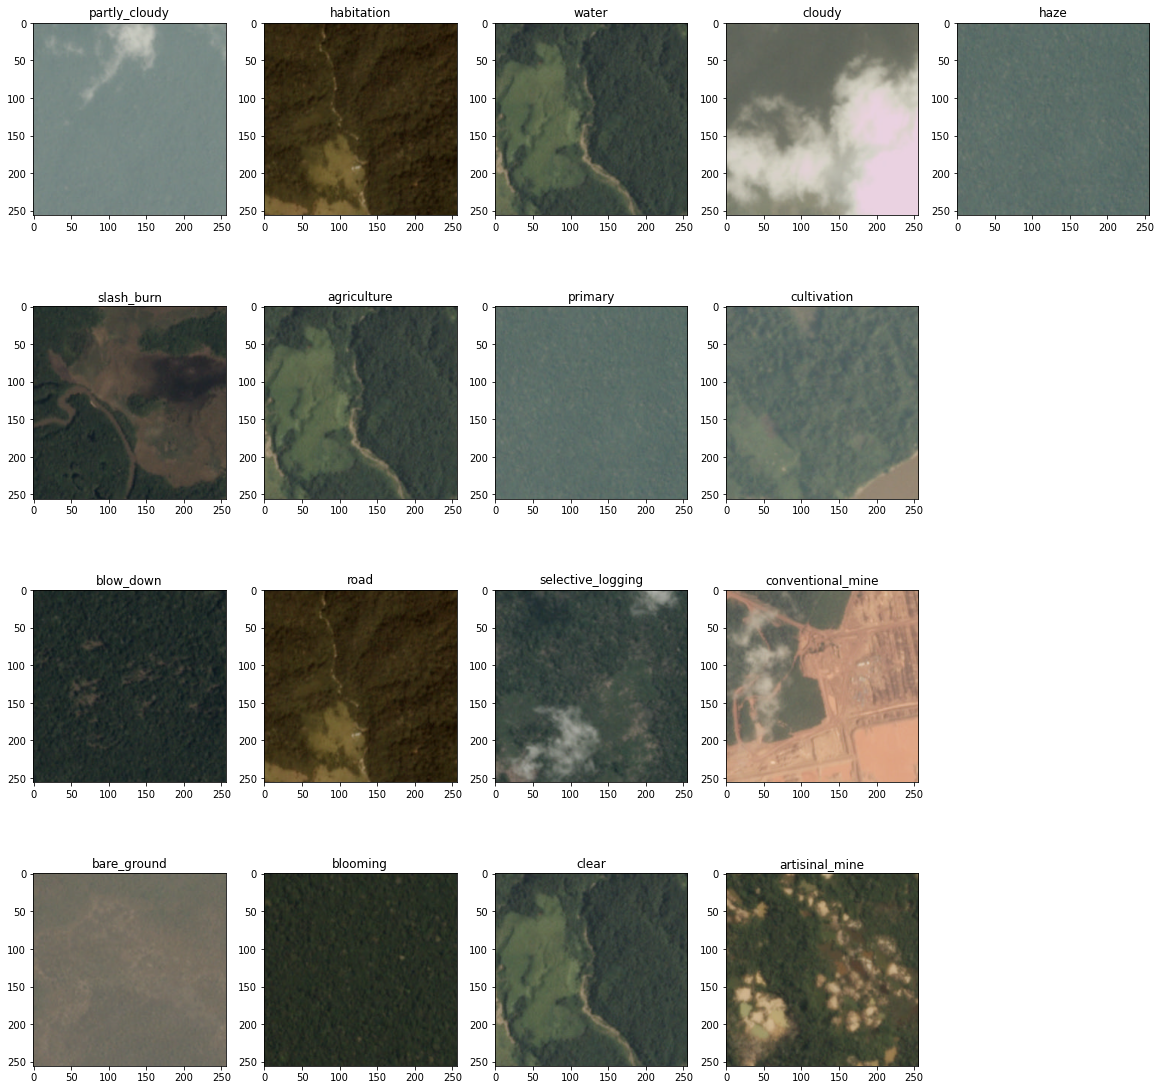

In [ ]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()
title = 'Class Sampling'
plt.savefig(experiment_results+title+".jpg")

In [ ]:
def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img

In [ ]:
filenames = df_class.image_name.sample(600).values
path_files = [os.path.join(path_train, filename+".jpg")
              for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
X_train_sample.shape

(600, 30000)

In [ ]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



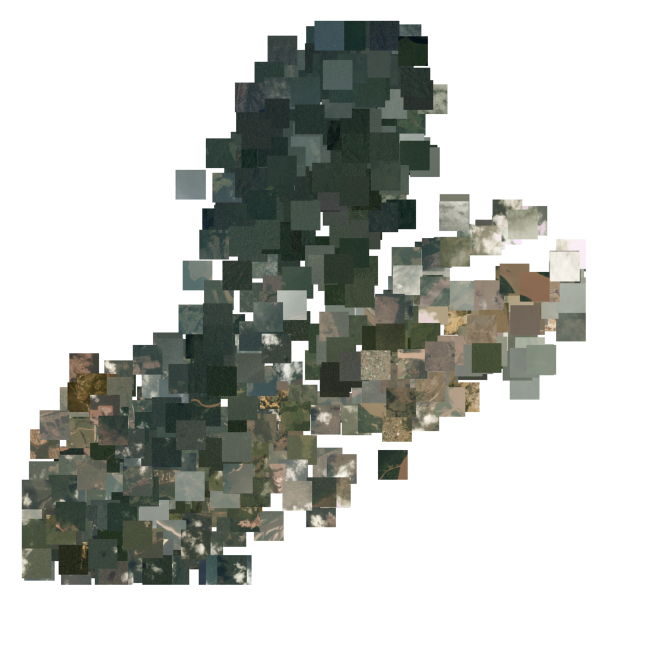

In [ ]:
def tsne_analysis():

    tsne = TSNE(
        n_components=2,
        init="random",
        random_state=101,
        method="barnes_hut",
        n_iter=500,
        verbose=0,
    )
    X_embedded = tsne.fit_transform(X_train_sample)

    size_img = 1000
    offset_img = 50
    h = w = int(offset_img / 2)

    X_scaled = (X_embedded - X_embedded.min(0)) / (X_embedded.max(0) - X_embedded.min(0))
    X_scaled = (X_scaled * size_img).astype(int)
    X_scaled = np.clip(X_scaled, offset_img, size_img-offset_img)

    img_tsne = np.ones((size_img+2*offset_img, size_img+2 * offset_img, 3), dtype=np.uint8) * 255
    for idx in range(X_scaled.shape[0]):
        x, y = X_scaled[idx][0], X_scaled[idx][1]
        img = fetch_img(path_files[idx], h, w)
        img_tsne[x-w:x+w, y-h:y+h, :] = img

    fig = plt.figure(figsize=(12, 12))
    plt.axis("off")
    title = 'TSNE Clustering'
    plt.savefig(experiment_results+title+".png")
    return plt.imshow(img_tsne)

tsne_analysis()


# Dataset loader

In [ ]:
# create image augmentations
transform_train = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], # Imagenet normalization
        )                                                          # TODO: Normalize from the current dataset
])

transform_val = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
        )
])

In [ ]:
class AmazonDatasetError(Exception):
    pass


class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform_train
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise AmazonDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise AmazonDatasetError(f"Can't fetch {filename} among {self.paths}")
        image = Image.open(file_path).convert("RGB")
        label = self.ohe_tags[idx]
        return image, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.transform(img)
            img.permute(2, 0, 1)
            imgs.append(img[None])
            labels.append(label[None])
        imgs = torch.cat(imgs).float()
        labels = torch.cat(labels).float()
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label} - {self.transform(img).shape}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)


In [ ]:
def get_data(df_train, df_val):

    encoder = MultiLabelBinarizer()
    ohe_tags_train = torch.tensor(encoder.fit_transform(df_train.list_tags.values))
    ohe_tags_val = torch.tensor(encoder.transform(df_val.list_tags.values))

    ds_train = AmazonDataset(df_train, ohe_tags_train,
                             transform_train, path=path_train)
    ds_val = AmazonDataset(df_val, ohe_tags_val,
                           transform_val, path=path_train)

    sample_weights = ohe_tags_train.shape[0]/ohe_tags_train.sum(axis=0)
    sample_weights = sample_weights.double()
    sampler = torch.utils.data.WeightedRandomSampler(
        sample_weights, len(sample_weights))

    dl_train = DataLoader(
        ds_train,
        batch_size=BATCH_SIZE,
        collate_fn=ds_train.collate_fn,
        # sampler=sampler,
        shuffle=True,
        prefetch_factor=8,
        pin_memory=True,
        num_workers=2,
        drop_last=True

    )
    dl_val = DataLoader(
        ds_val,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=ds_val.collate_fn,
        prefetch_factor=4,
        pin_memory=True,
        num_workers=2,
        drop_last=True
    )

    return ds_train, ds_val, dl_train, dl_val, encoder, ohe_tags_train

In [ ]:
ds_train, ds_val, dl_train, dl_val, encoder, ohe_tags_train = get_data(df_train, df_val)
classes = encoder.classes_
classes = list(classes)
def unitest_loader():
  imgs, labels = next(iter(dl_train))
  print(imgs.shape, labels.shape)

  imgs, labels = next(iter(dl_val))
  print(imgs.shape, labels.shape)

#unitest_loader()

### Utils

In [ ]:
def load_checkpoint(filename):
    try:
        checkpoint = torch.load(filename, map_location=torch.device(device))
        print(checkpoint.keys())
        epoch = checkpoint['epoch']
        model_state = checkpoint['model']
        optimizer_state = checkpoint['optimizer']
        lr_scheduler_state = checkpoint['lr_scheduler']
        max_accuracy = checkpoint['max_accuracy']
        epoch = checkpoint['epoch']
        #config = checkpoint['config']
        return checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy
    except:
        print("Not able to load checkpoint ",filename)


def load_results(filename):
    try:
        results = dict()
        results = pickle.load(open(filename,"rb"))
        score = results['score']
        loss = results['loss']
        y_epochs = results['y']
        Y_thresh = results['Y_thresh']
        configs = results['config']
        epochs = results['epoch']
        max_accuracy = results['max_accuracy']

        return results, score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy

    except Exception as e:
        print("Not able to load results")
        print(e)  


def remove_file(path):
    if OVERWRITE_CHECKPOINT:
        try:
            os.remove(path)
            print(f"File {path} removed")
            return
        except Exception as e:
            print(e) 
    print(f"Not able to remove {path}")  

def save_overwrite_checkpoints(checkpoint, file):
    remove_file(file)
    torch.save(checkpoint, file)
    print(f"File {file} updated")


def save_overwrite_results(results, file):
    remove_file(file)
    pickle.dump(results, open(file, "wb+"))    
    print(f"File {file} updated")

def print_arch():
  print([module for module in model.modules() if not isinstance(module, nn.Sequential)])
    
def print_weights():
    kl = list()
    #unfreeze_param = ["relative_position_index", "relative_coords_table", "attn_mask", "head", "relative_position_bias_table", "absolute_pos_embed"]
    unfreeze_param = ["head", "layers.3.blocks.1.mlp, layers.3.downsample.norm"]
    unfreeze_param = ["layers.3.blocks.1."]
    #unfreeze_param = ["head"]
    for k, v in model.state_dict().items():
        #v.requires_grad = False
        print(f"{k} requires grad {v.float().requires_grad}")
        for parameter in unfreeze_param:
            if parameter in k:
                freeze=False
                v=v.float()
                print(k,v)
                #v.requires_grad = True 
                print(f"unfreeze {k}")
                break
            freeze=True

        if freeze:
            #v.requires_grad = freeze
            kl.append(k)
            #print( k)  


# Model

## Loading pre-trained weights/checkpoints

In [ ]:
if RECOVER_PAST_TRAINNING:
    checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_checkpoint(checkpoint_path)
    results, score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy = load_results(results_path)
    print("recover_training")
else:
    if MODEL == 'resnet50_IMAGENET':
        model = models.resnet.resnet50(weights='IMAGENET1K_V1')
        model_state = model.state_dict()
    elif MODEL == 'swin_t_IMAGENET':
        model = models.swin_transformer.swin_t(weights='IMAGENET1K_V1')
        model_state = model.state_dict()
    else:
        checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_checkpoint(weights_path)
    results = {}

dict_keys(['epoch', 'model', 'optimizer', 'loss', 'max_accuracy', 'best_loss_val', 'lr_scheduler', 'config'])
recover_training


In [ ]:
def build_model_resnet_50(model_state):
    #https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

    model = models.resnet50()
    model.fc = nn.Sequential(
      nn.Linear(2048, 17), # 512 for resnet18 or 2048 for resnet 50
      nn.Sigmoid()
    )     

    if RECOVER_PAST_TRAINNING:
        info = model.load_state_dict(model_state, strict=True)
        return model.to(device)

    del model_state['fc.weight']
    del model_state['fc.bias']

    info = model.load_state_dict(model_state, strict=False)

    #for param in model.parameters():
    #    param.require_grad = False

    return model.to(device)


if MODEL == 'rsp-resnet-50':
    model = build_model_resnet_50(model_state)
    clear_cache()

In [ ]:
def build_model_swan_t(model_state):
    num_classes = 17
    swin_embed_dim = 768

    model = timm.models.swin_tiny_patch4_window7_224()

    if RECOVER_PAST_TRAINNING:
        model.head = nn.Linear(swin_embed_dim, num_classes)
        model = torch.nn.Sequential(model, torch.nn.Sigmoid())
        info = model.load_state_dict(model_state, strict=True)
        clear_cache()
        return model.to(device)

    state_dict = model_state

    # assuming that the head layer has 768 neurons, otherwise change it
    model.head = nn.Linear(swin_embed_dim, num_classes)
    #torch.nn.Sequential(model, torch.nn.Sigmoid())

    model = model.to(device)
    state_dict = model.state_dict()

    # delete relative_position_index since we always re-init it
    relative_position_index_keys = [k for k in state_dict.keys() if "relative_position_index" in k]
    for k in relative_position_index_keys:
        del state_dict[k]

    # delete relative_coords_table since we always re-init it
    relative_position_index_keys = [k for k in state_dict.keys() if "relative_coords_table" in k]
    for k in relative_position_index_keys:
        del state_dict[k]

    # delete attn_mask since we always re-init it
    attn_mask_keys = [k for k in state_dict.keys() if "attn_mask" in k]
    for k in attn_mask_keys:
        del state_dict[k]

    state_dict = model_state
    torch.nn.init.constant_(model.head.bias, 0.)
    torch.nn.init.constant_(model.head.weight, 0.)

    del state_dict['head.weight']
    del state_dict['head.bias']

    info = model.load_state_dict(state_dict, strict=False)
    print(info)
    model.head = nn.Linear(swin_embed_dim, num_classes)
    model = torch.nn.Sequential(model, torch.nn.Sigmoid())
 

    return model.to(device)


if MODEL == 'rsp-swin-t' :
    clear_cache()
    model = build_model_swan_t(model_state)



# Train setup

In [ ]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):     
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss.to(device)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.1, verbose=True, patience=1,
                                mode='min')
early_stopper = EarlyStopper(patience=2)
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
sample_weights = ohe_tags_train.shape[0]/ohe_tags_train.sum(axis=0) - 1
sample_weights = sample_weights.double().to(device)
#loss_fn = nn.BCELoss(weight=sample_weights)  # Binary Cross Entropy
#loss_fn = nn.BCELoss()  # Binary Cross Entropy
loss_fn = FocalLoss()
sample_weights

tensor([2.2920e+00, 1.1849e+02, 4.7333e+01, 1.2028e+02, 4.4260e+02, 4.2915e-01,
        1.8299e+01, 4.0379e+02, 8.1143e+00, 1.0143e+01, 1.3794e+01, 4.5299e+00,
        7.9505e-02, 4.0214e+00, 1.2452e+02, 1.9176e+02, 4.4471e+00],
       dtype=torch.float64)

### Batch fit/validate

In [ ]:
def fit_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X.to(device))
    batch_loss = loss_fn(Y_hat, Y.to(device))
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach()

    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X.to(device))
    batch_loss = loss_fn(Y_hat, Y.to(device))
    Y_hat = Y_hat.detach()

    return Y_hat, batch_loss.item()
# Test batch train

def unit_test_batch_train():
    clear_cache()
    X, Y = next(iter(dl_train))
    model.train()
    optimizer.zero_grad()
    print(X.shape)
    print(Y.shape)
    Y_hat = model(X.to(device))
    Y_hat[Y_hat < 0]
    batch_loss = loss_fn(Y_hat, Y.to(device))
    Y_hat = Y_hat.detach()
    clear_cache()

    
#unit_test_batch_train()

In [ ]:
def init_arrays(train_baches_epoch, val_baches_epoch):
    train_baches_epoch, val_baches_epoch = int(train_baches_epoch), int(val_baches_epoch)
    loss = dict()
    loss["train"] = np.zeros((N_EPOCHS,train_baches_epoch))
    loss["val"] = np.zeros((N_EPOCHS,train_baches_epoch))
    lr = np.zeros((N_EPOCHS,train_baches_epoch))
    score = dict()
    score["val"] = np.zeros(N_EPOCHS)
    score["train"] = np.zeros(N_EPOCHS)

    y_epoch = {'train': dict(), 'val': dict()}
    y_epoch["train"]["label"] = torch.zeros((N_EPOCHS, train_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["train"]["pred"] = torch.zeros((N_EPOCHS, train_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["val"]["label"] = torch.zeros((N_EPOCHS, val_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["val"]["pred"] = torch.zeros((N_EPOCHS, val_baches_epoch, BATCH_SIZE, FEATURES))

    return y_epoch, score, loss, lr
    
train_steps, val_steps = ds_train_size//BATCH_SIZE, ds_val_size//BATCH_SIZE
y_epoch, score, loss, lr = init_arrays(train_steps, val_steps)
print(train_steps)
print(y_epoch["train"]["label"][N_EPOCHS-1][train_steps-1][BATCH_SIZE-1][FEATURES-1])

505
tensor(0.)


In [ ]:
def eval_score(Y_true:Tensor, Y_pred:Tensor, threshold:float):
    Y_true = Y_true.cpu().numpy().reshape((-1,FEATURES))
    Y_pred = (Y_pred.cpu().numpy() > .2).astype(float).reshape((-1,FEATURES))
    return fbeta_score(Y_true,Y_pred,beta=2, average="samples")

t1, t2 = torch.zeros(FEATURES), torch.zeros(FEATURES)
t1[4], t2[7] = 1, 1
Y_true = torch.cat([t1,t2])
Y_pred = torch.cat([t2,t1])*0.8
print(Y_true)
print(Y_pred)
eval_score(Y_true, Y_pred, 0.5)

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.8000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


0.0

# Train

In [ ]:
def train_model(dl_train, dl_val, version, model, optimizer, loss_fn, lr_scheduler, results, checkpoint):
    train_steps, val_steps = ds_train_size//BATCH_SIZE, ds_val_size//BATCH_SIZE

    y_epoch, score, loss, lr = init_arrays(train_steps, val_steps)
    epoch_start = 0
    if results and RECOVER_PAST_TRAINNING:
        train_results = deepcopy(results)
        epoch_start = checkpoint['epoch']
        best_score_val = train_results["score_val"]
        lr_scheduler = checkpoint['lr_scheduler']
        
    Y_val, Y_hat = torch.zeros(FEATURES), torch.zeros(FEATURES)
    best_loss_val, best_score_val = torch.inf, 0
    Y_thresh_val = 0.2
    batch_loss = torch.inf
    for epoch in range(epoch_start, N_EPOCHS):

        for idx, (X, Y) in enumerate(tqdm(dl_train, leave=False)):
            Y_hat, batch_loss = fit_batch(X, Y, model, loss_fn, optimizer)
            loss["train"][epoch][idx] = batch_loss
            y_epoch["train"]["pred"][epoch][idx] = Y_hat
            y_epoch["train"]["label"][epoch][idx] = Y
            if idx > 0 and idx % 30 == 0:
                avg_loss = loss["train"][epoch][idx-LR_STEP_SIZE:idx+1].mean()
                it_score = eval_score(Y,Y_hat,Y_thresh_val)
                print(f'Train Loss: {avg_loss} score:{it_score}')
            #break

        for idx, (X, Y) in enumerate(tqdm(dl_val, leave=False)):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss["val"][epoch][idx] = batch_loss
            y_epoch["val"]["pred"][epoch][idx] = Y_hat
            y_epoch["val"]["label"][epoch][idx] = Y
            #break
        

        score['train'][epoch] = eval_score(y_epoch["train"]["label"][epoch],
                                          y_epoch["train"]["pred"][epoch], Y_thresh_val)
        score['val'][epoch] = eval_score(y_epoch["val"]["label"][epoch],
                                        y_epoch["val"]["pred"][epoch], Y_thresh_val)

        avg_loss_train = loss["train"][epoch].mean()
        avg_loss_val = loss["val"][epoch].mean()
        lr[epoch][idx] = optimizer.param_groups[0]['lr']
        lr_scheduler.step(metrics=avg_loss_val)

        print(
            f"epoch: {epoch}/{N_EPOCHS} -- train loss: {avg_loss_train}, "
            f"val loss: {avg_loss_val}"
            f" -- train fbeta_score: {score['train'][epoch]}, "
            f"val fbeta_score: {score['val'][epoch]}"
        )

        checkpoint = {
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': avg_loss_val,
            'max_accuracy': best_score_val,
            'best_loss_val': best_loss_val,
            'lr_scheduler': lr_scheduler.state_dict(),
            'config': config
        }

        results = {
            "loss": loss,
            "score": score,
            "y": y_epoch,
            'epoch': epoch,
            'best_loss_val': avg_loss_val,
            'max_accuracy': best_score_val,
            'config': config,
            'Y_thresh' : Y_thresh_val,
            'lr':lr
        }

        if avg_loss_val <= best_loss_val:
            save_overwrite_checkpoints(checkpoint, checkpoint_path)
        save_overwrite_results(results, results_path)

        best_loss_val = avg_loss_val if avg_loss_val < best_loss_val else best_loss_val
        best_score_val = score['val'][epoch] if best_score_val < score['val'][epoch] else best_score_val
        
        if early_stopper.early_stop(score['val'][epoch]):             
           pass
           #break

        #break

if TRAIN:
    clear_cache()
    train_model(dl_train, dl_val, VERSION, model, optimizer, loss_fn, lr_scheduler, results, checkpoint)


### Log Train progress swin_T

```
Train Loss: 0.012180973310023546 score:0.7534488015732439
Train Loss: 0.003948274767026305 score:0.8573815787600555
Train Loss: 0.0028051899280399084 score:0.8697028645102365
Train Loss: 0.0037427626084536314 score:0.8634330519277549
Train Loss: 0.0017343995859846473 score:0.8797631473097237
Train Loss: 0.0019682173733599484 score:0.8799202441401921
Train Loss: 0.0017133692163042724 score:0.8517999127213052
Train Loss: 0.0011914733331650496 score:0.9138936379252094
Train Loss: 0.0008872404869180173 score:0.9077276423293983
Train Loss: 0.0012014410458505154 score:0.9071959751988605
Train Loss: 0.0009346653532702476 score:0.9297892908942453
Train Loss: 0.0015000361599959433 score:0.8765808627420527
Train Loss: 0.0011179689900018275 score:0.9072161926517897
Train Loss: 0.0013691323692910373 score:0.895875360238056
Train Loss: 0.000787916244007647 score:0.8961066903632566
Train Loss: 0.0010295110987499356 score:0.8823783872037548

epoch: 0/10 -- train loss: 0.005578411231220857, val loss: 0.00022481461643416545 -- train fbeta_score: 0.8641226904287985, val fbeta_score: 0.9141578908537119
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_shm_lr_1_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_shm_lr_1_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.0010452867136336863 score:0.8991117178127386
Train Loss: 0.0007247500470839441 score:0.9196120092184545
Train Loss: 0.0009403713920619339 score:0.9202828021991625
Train Loss: 0.0008715625444892794 score:0.9078949882761218
Train Loss: 0.0006279447406996042 score:0.903015981471033
Train Loss: 0.0006491788954008371 score:0.9106008462605041
Train Loss: 0.00074781957664527 score:0.9007384940058312
Train Loss: 0.001548566564451903 score:0.8990268485753811
Train Loss: 0.0008740485063754022 score:0.9037680909093264
Train Loss: 0.0006790961779188365 score:0.9057863311434883
Train Loss: 0.0004897018952760845 score:0.9326276475068634
Train Loss: 0.0009281179227400571 score:0.914470693327964
Train Loss: 0.0011174920364283025 score:0.9155679247118308
Train Loss: 0.0008545361924916506 score:0.9028076269786071
Train Loss: 0.0006783638964407146 score:0.9332096941114127
Train Loss: 0.0005590967048192397 score:0.9257048018115841

epoch: 1/10 -- train loss: 0.0007660983694834856, val loss: 0.00017421544554855416 -- train fbeta_score: 0.9145196102590523, val fbeta_score: 0.9212841916086068
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_shm_lr_1_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_shm_lr_1_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.0004639099061023444 score:0.9350438700392745
Train Loss: 0.0006005956529406831 score:0.912764017377746
Train Loss: 0.0005195094854570925 score:0.9178074390698956
Train Loss: 0.0005991011275909841 score:0.928136015022788
Train Loss: 0.000538010528543964 score:0.9242073903307739
Train Loss: 0.0007490921125281602 score:0.9061065362974053
Train Loss: 0.0011717462621163577 score:0.9050815679201113
Train Loss: 0.0005196369311306626 score:0.9439268119476272
Train Loss: 0.0004256814863765612 score:0.9024613980514311
Train Loss: 0.0008500079566147178 score:0.9382717440481987
Train Loss: 0.0005791051080450416 score:0.9228957052783734
Train Loss: 0.0005351474392227829 score:0.9239655973783054
Train Loss: 0.0004914921446470544 score:0.9239676097654281
Train Loss: 0.00040198458009399474 score:0.9552376724233584
Train Loss: 0.0006614078010898083 score:0.9345257922215885
Train Loss: 0.0009036466362886131 score:0.9164100513936353

epoch: 2/10 -- train loss: 0.000614100583831291, val loss: 0.0001549260355393854 -- train fbeta_score: 0.9205202049143518, val fbeta_score: 0.9247083658543841
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_shm_lr_1_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_shm_lr_1_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.0005713930731872097 score:0.9235418890187255
Train Loss: 0.0003772301715798676 score:0.9358933641276277
Train Loss: 0.0005405035335570574 score:0.9064142729620024
Train Loss: 0.0006710035959258676 score:0.9111275146106671
Train Loss: 0.0004519904759945348 score:0.9094079387048137
Train Loss: 0.00016855330613907427 score:0.9414141067832209
Train Loss: 0.00032179611298488453 score:0.9390838328338329
Train Loss: 0.0007436637824866921 score:0.9162033272354497
Train Loss: 0.000615585595369339 score:0.9014513290018804
Train Loss: 0.0003696087223943323 score:0.934362759459351
Train Loss: 0.0003748554881894961 score:0.9332895791550322
Train Loss: 0.0007052550572552718 score:0.8975882038363898
Train Loss: 0.00037369698111433536 score:0.9269564621677423
Train Loss: 0.0003643968375399709 score:0.9416542998804028
Train Loss: 0.0003780732076847926 score:0.9257006254826081
Train Loss: 0.0008953194483183324 score:0.8897762154628034

epoch: 3/10 -- train loss: 0.0005280135385720935, val loss: 0.00014825710455661104 -- train fbeta_score: 0.9237074948668236, val fbeta_score: 0.9227950393177103
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_shm_lr_1_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_shm_lr_1_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.0006438301643356681 score:0.8908275188919454
Train Loss: 0.00047683333104941994 score:0.9215351872714489
Train Loss: 0.00041491573210805655 score:0.9325177591438134
Train Loss: 0.00045060142292641103 score:0.9359760927241447
Train Loss: 0.0003864070604322478 score:0.9191250067495713
Train Loss: 0.00027218827744945884 score:0.9428052092643234
Train Loss: 0.0005819471261929721 score:0.9233452960209585
Train Loss: 0.000465852179331705 score:0.9366000248263738
Train Loss: 0.0006525295320898294 score:0.9306337213237463
Train Loss: 0.000627521876594983 score:0.9170317825334473
Train Loss: 0.0006638462655246258 score:0.8987480131575222
Train Loss: 0.0005877921066712588 score:0.9144998929429561
Train Loss: 0.0003159448242513463 score:0.940067285655521
Train Loss: 0.00039033514622133225 score:0.929653461905237
Train Loss: 0.00040060428727883846 score:0.9140268900820613
Train Loss: 0.00029840366187272593 score:0.9263368151447438

epoch: 4/10 -- train loss: 0.00047056143743211937, val loss: 0.00013990431724607226 -- train fbeta_score: 0.9271542751245664, val fbeta_score: 0.9265287274485929
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_shm_lr_1_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_shm_lr_1_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.000323486136039719 score:0.9472172127677843
Train Loss: 0.0002772826628643088 score:0.957956410718059
Train Loss: 0.00022598529540118761 score:0.9430362777689183
Train Loss: 0.0005879981472389773 score:0.9141050567352469
Train Loss: 0.00038541859248653054 score:0.9204401985881765
Train Loss: 0.00029157268727431074 score:0.9346542049526216
Train Loss: 0.00044438692566473037 score:0.9364084293441949
Train Loss: 0.0006440684956032783 score:0.8977959577093984
Train Loss: 0.00041633660293882713 score:0.9630472645487542
Train Loss: 0.0004741083102999255 score:0.9498019575570127
Train Loss: 0.00033471993810962886 score:0.9173500924521787
Train Loss: 0.00038620398117927834 score:0.9529323546121731
Train Loss: 0.0003141218767268583 score:0.9276040633692288
Train Loss: 0.00028780109278159216 score:0.9093733804653165
Train Loss: 0.0006501965108327568 score:0.9263826818163643
Train Loss: 0.0004779256705660373 score:0.9152650052462913

epoch: 5/10 -- train loss: 0.00042301396345708166, val loss: 0.00014144337976969187 -- train fbeta_score: 0.9295646806453998, val fbeta_score: 0.9259892648141781
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.0005211153766140342 score:0.9262570695480102
Train Loss: 0.00035975014907307923 score:0.9270665699512691
Train Loss: 0.00020460487576201558 score:0.9538303468430547
Train Loss: 0.00037722871638834476 score:0.9238288247943979
Train Loss: 0.0003377908142283559 score:0.9319110693586488
Train Loss: 0.00015668831474613398 score:0.9527204399393251
Train Loss: 0.0005581822479143739 score:0.9090786400118489
Train Loss: 0.00029230242216726765 score:0.9384131321738061
Train Loss: 0.00020908953592879698 score:0.955984556591389
Train Loss: 0.00043514750723261386 score:0.9107206728190584
Train Loss: 0.0002790078942780383 score:0.9279141868960643
Train Loss: 0.00020668740762630478 score:0.9360626483192342
Train Loss: 0.00023601786961080506 score:0.9426126561427663
Train Loss: 0.0004083698004251346 score:0.9198596552923703
Train Loss: 0.00041742513712961227 score:0.9230543716541997
Train Loss: 0.0004978902725270018 score:0.927086828109846

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
epoch: 6/10 -- train loss: 0.0003792775856961478, val loss: 0.0001461672866924454 -- train fbeta_score: 0.9328483086132016, val fbeta_score: 0.9234749144360347
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.00035060108348261565 score:0.9071062362882216
Train Loss: 0.00021590387041214854 score:0.9253553244571016
Train Loss: 0.00028278445824980736 score:0.9285976455457245
Train Loss: 0.00024303833924932405 score:0.9404149113636626
Train Loss: 0.00022212420299183577 score:0.9306457623420181
Train Loss: 0.00030476377287413925 score:0.9110260704480437
Train Loss: 0.0002658013254404068 score:0.9305194519148801
Train Loss: 0.00028466687217587605 score:0.9104356628350436
Train Loss: 0.0002728342660702765 score:0.9351866297160657
Train Loss: 0.00030313312890939415 score:0.9480545075329083
Train Loss: 0.0002328896225662902 score:0.9341621240523295
Train Loss: 0.00044957791396882385 score:0.9269286864923049
Train Loss: 0.0002655806893017143 score:0.9240126410048285
Train Loss: 0.0002830931334756315 score:0.936794455416786
Train Loss: 0.00020438166393432766 score:0.9540385898223527
Train Loss: 0.00013651721747010015 score:0.9517715782651445

epoch: 7/10 -- train loss: 0.0002865336820976532, val loss: 0.0001241633084448202 -- train fbeta_score: 0.9389981740158773, val fbeta_score: 0.928687729923253
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_shm_lr_1_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_shm_lr_1_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.00018860376439988613 score:0.9420549431972087
Train Loss: 0.0007174235361162573 score:0.9191430723762317
Train Loss: 0.0002951312199002132 score:0.9340303512227512
Train Loss: 0.00017893466429086402 score:0.9487500556678985
Train Loss: 0.00020919253074680455 score:0.9646816255581152
Train Loss: 0.00016719090490369126 score:0.9595858773901538
Train Loss: 0.00025566456315573305 score:0.9483861135630437
Train Loss: 0.0002749466439126991 score:0.9471333338737473
Train Loss: 0.00021570241369772702 score:0.9584871978230185
Train Loss: 0.00012634130325750448 score:0.9501214275172428
Train Loss: 0.00019621347746578977 score:0.933844109012132
Train Loss: 0.00034414110996294767 score:0.9407121512898651
Train Loss: 0.00030448542383965105 score:0.9366728170726333
Train Loss: 7.43348864489235e-05 score:0.962995756862129
Train Loss: 0.0004229767801007256 score:0.9238251137801254
Train Loss: 0.00033307087142020464 score:0.9288023480808407

epoch: 8/10 -- train loss: 0.0002499249327301375, val loss: 0.00012290180170341478 -- train fbeta_score: 0.9425264599874089, val fbeta_score: 0.9285622026789621
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_shm_lr_1_10-epoch_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_shm_lr_1_10-epoch_final.pth updated
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl updated

Train Loss: 0.00022676813387079164 score:0.9451184894490474
Train Loss: 0.00014237881259759888 score:0.9581785975972557
Train Loss: 0.00021449512132676318 score:0.945548223761514
Train Loss: 0.0001194408760056831 score:0.9586820285035889
Train Loss: 0.0002867494695237838 score:0.939650162739681
Train Loss: 0.00019632051771623082 score:0.9379651775852575
Train Loss: 0.00012396572128636762 score:0.9595753269563254
Train Loss: 0.0003550033216015436 score:0.9230321688158845
Train Loss: 0.00032474422187078744 score:0.9454554609946586
Train Loss: 5.535783202503808e-05 score:0.9684111618488767
Train Loss: 0.00029956067737657577 score:0.9211377789066892
Train Loss: 0.00017075844152714126 score:0.9681855177604259
Train Loss: 0.0002056425073533319 score:0.9402106969317447
Train Loss: 0.00027494083042256534 score:0.940736299101752
Train Loss: 0.00014960928092477843 score:0.960539931427048
Train Loss: 0.0002402767859166488 score:0.9436529769921556

epoch: 9/10 -- train loss: 0.00023111318842704423, val loss: 0.00012347078655954765 -- train fbeta_score: 0.9435062954786638, val fbeta_score: 0.9277413989589909
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_shm_lr_1_10-epoch_final.pkl updated

```

### Train Progress resnet

###

# Analysis

In [ ]:
results, score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy = load_results(results_path)
checkpoint, best_epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_checkpoint(checkpoint_path)

dict_keys(['epoch', 'model', 'optimizer', 'loss', 'max_accuracy', 'best_loss_val', 'lr_scheduler', 'config'])


## Training statistics

In [ ]:
def moving_average(series, window):
    y = np.zeros(len(series) - window)
    std = np.zeros(len(series) - window)
    confidence_interval = np.zeros(len(series) - window)
    for i in range(len(y)):
        y[i] = series[i:i+window].mean()
        std[i] = series[i:i+window].std()
        confidence_interval[i] = series[i:i+window].std()*1.96/np.sqrt(window)
    return y, confidence_interval

moving_average(loss['train'].flatten(), window=10)    

def confidence_interval(series):
    std = series.std(axis=1)
    return std * 1.96/np.sqrt(std.size)

#confidence_interval(loss['val'])

In [ ]:
loss['val'].mean(axis=1) + val_confidence_interval

array([0.00049132, 0.00038953, 0.00034257, 0.00033145, 0.00031922,
       0.000314  , 0.00032903, 0.00028081, 0.00027687, 0.00027963])

In [ ]:
filtered_loss, train_confidence_interval = moving_average(loss['train'].flatten(), window=BATCH_SIZE)

eps = 1e-4
train_lower_bound = filtered_loss - train_confidence_interval
train_lower_bound[train_lower_bound <= 0 ] = eps
val_confidence_interval = confidence_interval(loss['val'])
val_x_axis = np.arange(1,len(loss['train'].mean(axis=1))+1)*ds_train_size//BATCH_SIZE - BATCH_SIZE
fig = go.Figure([
    go.Scatter(
        name='Trainning Loss',
        x=np.arange(1,len(filtered_loss)+1),
        y= filtered_loss,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=np.arange(1,len(filtered_loss)+1),
        y=filtered_loss + train_confidence_interval,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=np.arange(1,len(filtered_loss)+1),
        y = train_lower_bound,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    ),

    go.Scatter(
        name='Validation Loss',
        x=val_x_axis,
        y = loss['val'].mean(axis=1),
        marker=dict(color="#0A0"),
        line=dict(width=1),
        mode='lines',
        showlegend=True
    ),
    go.Scatter(
        name='Upper Bound',
        x=val_x_axis,
        y=loss['val'].mean(axis=1) + val_confidence_interval,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    )
    
])
title = 'Training Loss Per Minibatch'
fig.update_layout(
    yaxis_title='Log Loss',
    xaxis_title='Mini-batch iteration',
    title='Training loss per minibatch',
    hovermode="x"
)
fig.update_yaxes(type="log", range=[-4, -1])
#fig.update_xaxes(type="log")
fig.update_layout(width=600, height=600)
fig.write_image(experiment_results+title+".jpg")
fig.show()

In [ ]:
def eval_epoch_scores(Y_label_eval, Y_pred_eval, thresh):
    batches = Y_label_eval.shape[1]
    epochs = Y_label_eval.shape[0]
    batches_scores = np.zeros((epochs, batches))

    for epoch_idx in range(epochs):
        for batch_idx in range(batches):
            batches_scores[epoch_idx][batch_idx] = eval_score(Y_label_eval[epoch_idx][batch_idx],
                                                Y_pred_eval[epoch_idx][batch_idx], thresh)
    return batches_scores.mean(axis=1), confidence_interval(batches_scores)

#eval_epoch_scores(results['y']['val']["label"], results['y']['val']["pred"], 0.2)                                             

In [ ]:
train_score, train_confidence = eval_epoch_scores(results['y']['train']["label"], results['y']['train']["pred"], 0.2)
val_score, val_confidence = eval_epoch_scores(results['y']['val']["label"], results['y']['val']["pred"], 0.2)

In [ ]:
fig = go.Figure([
        go.Scatter(
            x=list(range(train_score.size)),
            y=train_score,
            name="score_train",
            error_y_array=train_confidence
        ),
        go.Scatter(
            x=list(range(val_score.size)),
            y=val_score,
            name="score_val",
            error_y_array=val_confidence
        )
    ])
title = 'Training Loss Per Epoch'    
fig.update_layout(
    yaxis_title='Log Loss',
    xaxis_title='Mini-batch iteration',
    title=title,
    hovermode="x",
    width=500, height=500
)
fig.write_image(experiment_results+title+".jpg")



## Classifier evaluation

### Using validation set from best epoch

In [ ]:
Y_hat_val = results['y']['val']["pred"][best_epoch].reshape(-1,FEATURES).numpy()
Y_val = results['y']['val']["label"][best_epoch].reshape(-1,FEATURES).numpy()
Y_hat_val.shape

(8064, 17)

In [ ]:
pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
fig = go.Figure([
    go.Bar(x=list(encoder._cached_dict),
           y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict),
           y=neg_probas, name="Y_hat proba | Y = 0")
])
title = "Marginal Probabilities Per Class"
fig.update_layout(width=1000, height=500, title=title)
fig.write_image(experiment_results+title+".jpg")
fig.show()


In [ ]:
def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx

    global_best_score = fbeta_score(
        Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    return best_threshs

best_threshs = find_best_thresholds(Y_hat_val, Y_val)


  0%|          | 0/17 [00:00<?, ?it/s]

threshs: [0.14, 0.09, 0.13, 0.66, 0.14, 0.09, 0.11, 0.13, 0.29, 0.16, 0.24, 0.07, 0.24, 0.17, 0.15, 0.11, 0.15] -- best score: 0.9311284295555521


In [ ]:
def classify(probs):
    return (probs > best_threshs).astype(float)

def classify_class(probs, class_idx):
    return (probs[:, class_idx].ravel() > best_threshs[class_idx]).astype(float)
    
#classify(Y_hat_val)
#classify_class(y_pred, 7)

In [ ]:
def plot_score_per_tag(threshs):
    class_scores = {}
    classes = encoder.classes_
    for jdx in range(Y_val.shape[1]):
        y_val = Y_val[:, jdx].ravel()
        score = fbeta_score(y_val, classify_class(Y_hat_val, jdx), beta=2)
        class_scores[classes[jdx]] = round(score, 4)

    df_score = pd.DataFrame(dict(
        label=list(class_scores.keys()), score=list(class_scores.values()),
    )).sort_values("score", ascending=True)
    fig = px.bar(df_score, x="label", y="score", color="score")
    fig.update_layout(
        title='Score Per Class Using Optimal Thresholds',
        width=800, height=400
    )
    fig.show()
    fig.write_image(experiment_results+"Score Per Class Using Optimal Thresholds.jpg")
    return df_score

    
df_score = plot_score_per_tag(best_threshs)


In [ ]:
df_score

label   score
3            blooming  0.0194
4           blow_down  0.2778
15         slash_burn  0.2791
2         bare_ground  0.4380
14  selective_logging  0.4941
7   conventional_mine  0.5789
8         cultivation  0.6530
10               haze  0.7740
9          habitation  0.7804
16              water  0.8398
1      artisinal_mine  0.8422
13               road  0.8772
0         agriculture  0.8998
6              cloudy  0.9062
11      partly_cloudy  0.9456
5               clear  0.9782
12            primary  0.9916

In [ ]:
plot_idx = 0

def get_plot_coords():
    global plot_idx
    row = plot_idx // 4+1
    col = plot_idx % 4+1
    plot_idx +=1
    return col, row

fig = make_subplots(cols=5, rows=5)
for jdx in range(Y_val.shape[1]):

    y_val = Y_val[:, jdx].ravel()
    y_hat_val_class = classify_class(Y_hat_val, jdx)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val_class).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col, row = get_plot_coords()

    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"],
                         [f"tp: {tp}", f"fp: {fp}"]],
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row,
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)


fig.update_layout(width=800, height=1000, title="Confusion Matrices")
fig.show()
fig.write_image(experiment_results+"Confusion Matrices.jpg")


In [243]:
y_true = results['y']['val']['label'][best_epoch].reshape((-1,FEATURES)).numpy()
y_pred = results['y']['val']['pred'][best_epoch].reshape((-1,FEATURES)).numpy()

fig1 = go.Figure()
fig1.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1, name='no_skill'
)

fig2 = go.Figure()
fig2.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=0
)
pr_auc = pd.DataFrame()
roc_auc = pd.DataFrame()
for i in range(y_true.shape[1]):
    y_true_class = y_true[:, i]
    y_pred_class = y_pred[:, i]

    if not classes[i] in RARE_CLASSES:
        continue


    precision, recall, fbeta, support = precision_recall_fscore_support(y_true_class, y_pred_class>0.2, average='binary')
    precision, recall, thresholds= precision_recall_curve(y_true_class, y_pred_class)
    pr_auc = auc(recall, precision)
    no_skill_score = y_true_class.sum()/y_true_class.size
    name = f"{classes[i]} \n (AUC={fbeta:.3f}, no-skill={no_skill_score:.3f})"
    fig2.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'))

    fpr, tpr, _ = roc_curve(y_true_class, y_pred_class)
    auc_score = roc_auc_score(y_true_class, y_pred_class, average='macro')
    name = f"{classes[i]} \n (AUC={auc_score:.3f})"
    fig1.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig1.add_trace(go.Scatter(x=[0,1], y=[0,1], name="no-skill (AUC=0.5)", mode='lines'))    

title = 'ROC Curve Rare Classes'
fig1.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    #yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=800, height=500,
    title = 'ROC Curve'
)
fig2.write_image(experiment_results+title+".jpg")
fig1.show()
fig2.update_layout(
    yaxis_title='Precision',
    xaxis_title='Recall',
    #yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=800, height=500,
    title = 'PR Curve'
)
title = 'PR Curve Rare Classes'
fig2.write_image(experiment_results+title+".jpg")
fig2.show()


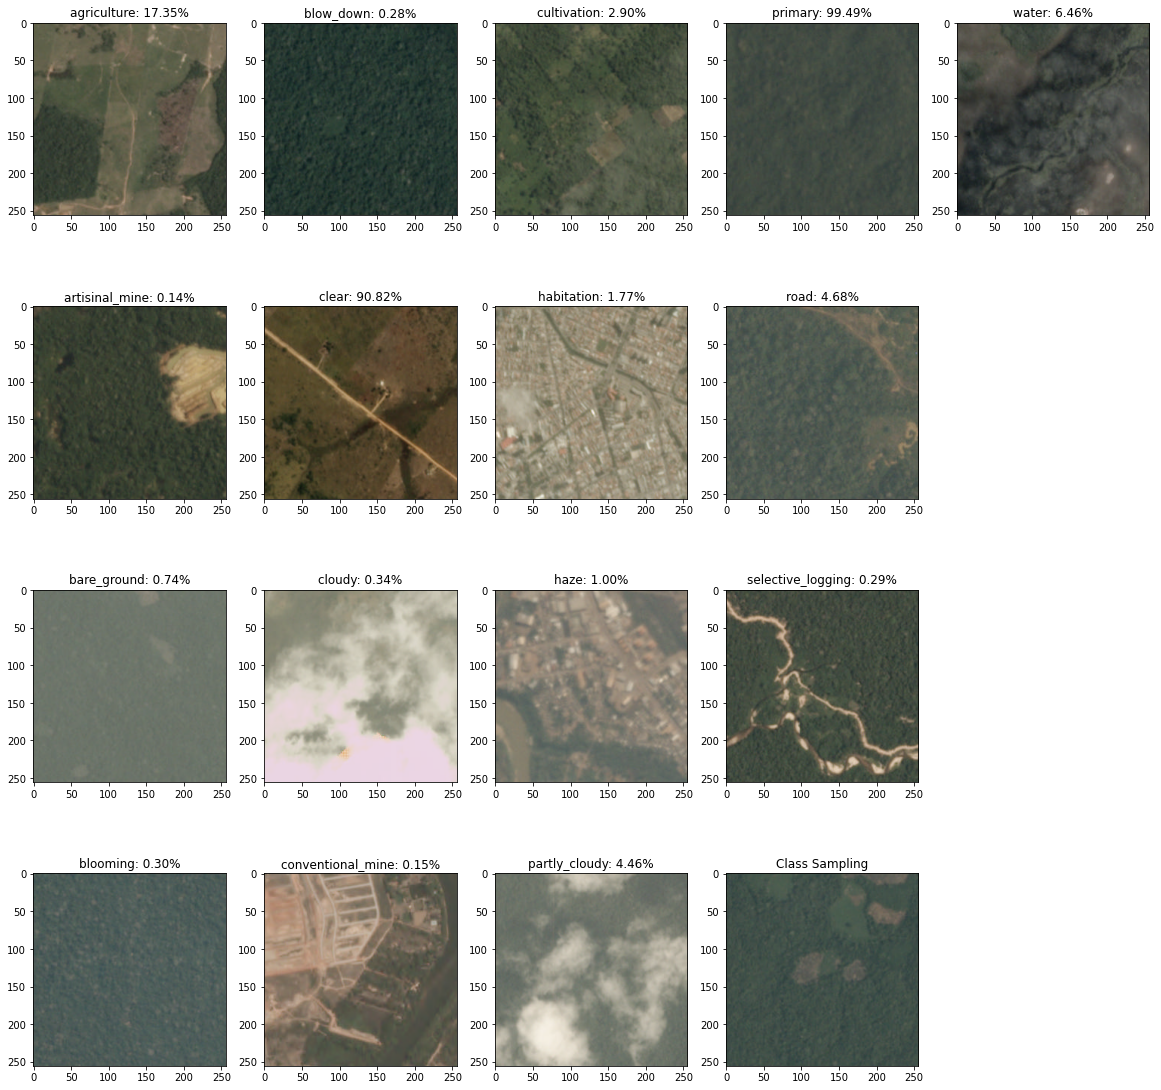

<Figure size 432x288 with 0 Axes>

In [239]:
N_tags = len(classes)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(classes):
    filename = df_val.loc[df_val.tags.str.contains(tag)].image_name.values[idx]
    img = Image.open(os.path.join(path_train, filename+".jpg")).convert("RGB")
    X = transform_val(img)[None, :]
    sample_pred = model(X.to(device)).detach().numpy()
    y_classes = classify(sample_pred)
    _, index_class = np.where(y_classes == 1)
    legend = ""
    for i in index_class:
      legend = legend + f"{classes[i]}: {sample_pred[0][i]*100:2.2f}% \n"
    legend = f'{classes[idx]}: {sample_pred[0][idx]*100:2.2f}%'
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(legend)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()
title = 'Class Sampling'
plt.title(title)
plt.show()
plt.savefig(experiment_results+title+".jpg")

In [ ]:
if RunningInCOLAB:
    #files.download(results_path)
    #files.download(checkpoint_path)
    #!sleep 600
    #runtime.unassign()
    pass

In [242]:
y_true = results['y']['val']['label'][best_epoch].reshape((-1,FEATURES)).numpy()
y_pred = results['y']['val']['pred'][best_epoch].reshape((-1,FEATURES)).numpy()

fig1 = go.Figure()
fig1.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1, name='no_skill'
)

fig2 = go.Figure()
fig2.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=0
)
pr_auc = pd.DataFrame()
roc_auc = pd.DataFrame()
for i in range(y_true.shape[1]):
    y_true_class = y_true[:, i]
    y_pred_class = y_pred[:, i]

    precision, recall, fbeta, support = precision_recall_fscore_support(y_true_class, y_pred_class>0.2, average='binary')
    precision, recall, thresholds= precision_recall_curve(y_true_class, y_pred_class)
    pr_auc = auc(recall, precision)
    no_skill_score = y_true_class.sum()/y_true_class.size
    name = f"{classes[i]} \n (AUC={fbeta:.3f}, no-skill={no_skill_score:.3f})"
    fig2.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'))

    fpr, tpr, _ = roc_curve(y_true_class, y_pred_class)
    auc_score = roc_auc_score(y_true_class, y_pred_class, average='macro')
    name = f"{classes[i]} \n (AUC={auc_score:.3f})"
    fig1.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig1.add_trace(go.Scatter(x=[0,1], y=[0,1], name="no-skill (AUC=0.5)", mode='lines'))    

title = 'ROC Curve All Classes'
fig1.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    #yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=800, height=600,
    title = 'ROC Curve'
)
fig2.write_image(experiment_results+title+".jpg")
fig1.show()
fig2.update_layout(
    yaxis_title='Precision',
    xaxis_title='Recall',
    #yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=800, height=600,
    title = 'PR Curve'
)
title = 'PR Curve All Classes'
fig2.write_image(experiment_results+title+".jpg")
fig2.show()
